# 2D Heat Equation

del_u/del_t = alpha*(del_square_u/del_x_square + del_square_u/del_y_square)

Boundary Conditions

u(0,y,t) = 0

u(1,y,t) = 0

u(x,0,t) = 0

u(x,1,t) = 0

Initial Conditions

u(x,y,0) = sin(pix)sin(pi*y)

In [1]:
import torch
from torch import nn
import numpy as np
from torch.optim.lr_scheduler import StepLR
class PINN(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=3, out_features=32)
    self.layer2 = nn.Linear(in_features=32, out_features=32)
    self.layer3 = nn.Linear(in_features=32, out_features=32)
    self.layer4 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.relu(self.layer3(x))
    x = self.layer4(x)

    return x



In [2]:
alpha = 0.01 # thermal diffusivity
epochs = 200000

learning_rate = 0.01

model = PINN()
optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size=50000, gamma=0.1)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

In [3]:
# Generate Traning Data

x = torch.rand(100,1, requires_grad=True)
y = torch.rand(100,1, requires_grad=True)
t = torch.rand(100,1, requires_grad=True)

In [4]:
# Initial Condition data

x_ic = torch.rand(100,1, requires_grad=True)
y_ic = torch.rand(100,1, requires_grad=True)
t_ic = torch.rand(100,1, requires_grad=True)
u_ic = torch.sin(np.pi*x_ic)*torch.cos(np.pi*y_ic)

In [5]:
# Boundary condition data

t_bc = torch.rand(100,1, requires_grad=True)
x_bc_0 = torch.zeros(100,1,requires_grad=True)
x_bc_1 = torch.ones(100,1,requires_grad=True)
y_bc_0 = torch.zeros(100,1,requires_grad=True)
y_bc_1 = torch.ones(100,1,requires_grad=True)


In [6]:
def pde_loss(model,x,y,t):
  # u_pred = model(torch.cat([x,y,t],dim=1))
  # u_t = torch.autograd.grad(u_pred, t, grad_outputs = torch.ones_like(u_pred), create_graph = True)[0]
  # u_x = torch.autograd.grad(u_pred, x, grad_outputs = torch.ones_like(u_pred), create_graph = True)[0]
  # u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u_x), create_graph = True, retain_graph=True)[0]
  # u_y = torch.autograd.grad(u_pred, y, grad_outputs = torch.ones_like(u_pred), create_graph = True)[0]
  # u_yy = torch.autograd.grad(u_y, y, grad_outputs = torch.ones_like(u_y), create_graph = True)[0]
  u_pred = model(torch.cat([x, y, t], dim=1))
  u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
  u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
  u_y = torch.autograd.grad(u_pred, y, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

  pde_residual = u_t - alpha*(u_xx+u_yy)
  return mae_loss(pde_residual, torch.zeros_like(pde_residual))

In [7]:
def initial_condition_loss(model, x_ic, y_ic, t_ic, u_ic):
  u_ic_pred = model(torch.cat([x_ic,y_ic,t_ic],dim=1))
  return mse_loss(u_ic_pred, u_ic)

In [8]:
def boundary_condition_loss(model, x_bc, y_bc, t_bc):
  u_bc_pred = model(torch.cat([x_bc, y_bc, t_bc],dim=1))
  # return mse_loss(u_bc_pred, torch.zeros_like(u_bc_pred))
  return mae_loss(u_bc_pred, torch.zeros_like(u_bc_pred))

In [24]:

losses = []
for epoch in range(epochs):
  optimizer.zero_grad()

  loss_pde = pde_loss(model,x,y,t)
  loss_ic = initial_condition_loss(model, x_ic, y_ic, t_ic, u_ic)

  # Boundary conditions for x = 0, x = 1, y = 0 and y = 1
  loss_bc_x0 = boundary_condition_loss(model, x_bc_0, y, t_bc)
  loss_bc_x1 = boundary_condition_loss(model, x_bc_1, y, t_bc)

  loss_bc_y0 = boundary_condition_loss(model, x, y_bc_0, t_bc)
  loss_bc_y1 = boundary_condition_loss(model, x, y_bc_1, t_bc)

  loss_bc = loss_bc_x0 + loss_bc_x1 + loss_bc_y0 + loss_bc_y1

  loss = loss_pde + loss_ic + loss_bc
  losses.append(loss.item())
  loss.backward(retain_graph=True)

  optimizer.step()
  scheduler.step()

  if epoch%1000==0:
    print(f'Epoch: {epoch} | Loss: {loss} | Learning Rate Value: {scheduler.get_last_lr()[0]}')

Epoch: 0 | Loss: 0.03198077529668808 | Learning Rate Value: 0.001
Epoch: 1000 | Loss: 0.032352279871702194 | Learning Rate Value: 0.001
Epoch: 2000 | Loss: 0.03177822008728981 | Learning Rate Value: 0.001
Epoch: 3000 | Loss: 0.03314989060163498 | Learning Rate Value: 0.001
Epoch: 4000 | Loss: 0.03150214999914169 | Learning Rate Value: 0.001
Epoch: 5000 | Loss: 0.031858012080192566 | Learning Rate Value: 0.001
Epoch: 6000 | Loss: 0.031211066991090775 | Learning Rate Value: 0.001
Epoch: 7000 | Loss: 0.03162449225783348 | Learning Rate Value: 0.001
Epoch: 8000 | Loss: 0.0317806676030159 | Learning Rate Value: 0.001
Epoch: 9000 | Loss: 0.032120052725076675 | Learning Rate Value: 0.001
Epoch: 10000 | Loss: 0.031383804976940155 | Learning Rate Value: 0.001
Epoch: 11000 | Loss: 0.0316305086016655 | Learning Rate Value: 0.001
Epoch: 12000 | Loss: 0.03208133205771446 | Learning Rate Value: 0.001
Epoch: 13000 | Loss: 0.029925428330898285 | Learning Rate Value: 0.001
Epoch: 14000 | Loss: 0.030008

In [25]:
with torch.inference_mode():
    u_bc_x0_pred = model(torch.cat([x_bc_0, y_ic, t_ic], dim=1))

In [26]:
with torch.inference_mode():
    u_ic_pred = model(torch.cat([x_ic, y_ic, t_ic], dim=1))

In [27]:
import matplotlib.pyplot as plt

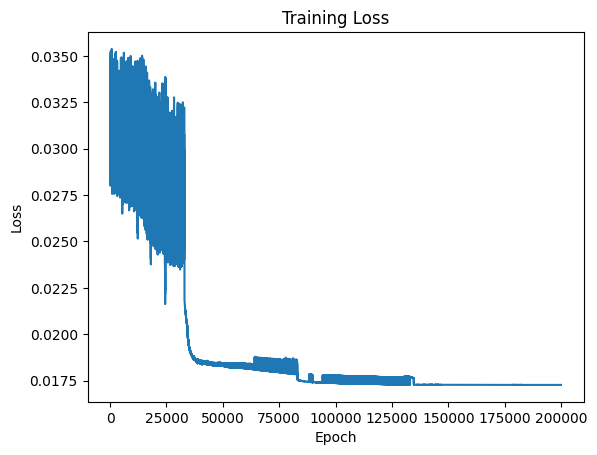

In [28]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

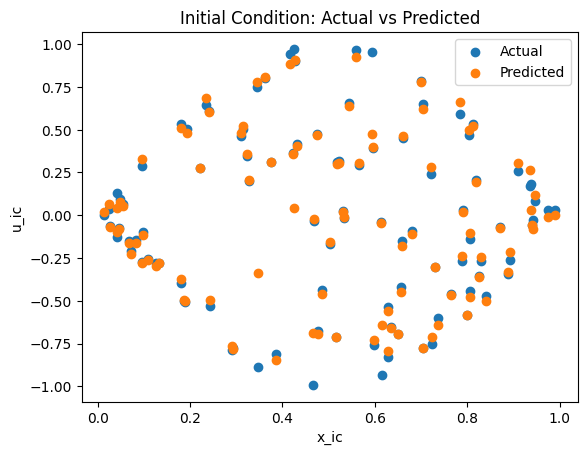

In [29]:
plt.figure()
plt.scatter(x_ic.detach().numpy(), u_ic.detach().numpy(), label='Actual')
plt.scatter(x_ic.detach().numpy(), u_ic_pred.detach().numpy(), label='Predicted')
plt.xlabel('x_ic')
plt.ylabel('u_ic')
plt.legend()
plt.title('Initial Condition: Actual vs Predicted')
plt.show()

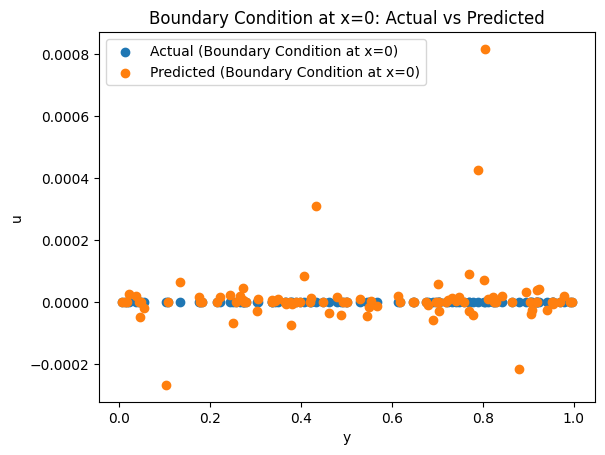

In [30]:
plt.figure()
plt.scatter(y.detach().numpy(), torch.zeros_like(y).numpy(), label='Actual (Boundary Condition at x=0)')
plt.scatter(y.detach().numpy(), u_bc_x0_pred.numpy(), label='Predicted (Boundary Condition at x=0)')
plt.xlabel('y')
plt.ylabel('u')
plt.legend()
plt.title('Boundary Condition at x=0: Actual vs Predicted')
plt.show()